<font size="+3"><strong>6.4. Interactive Dashboard</strong></font>

In the last lesson, we built a model based on the highest-variance features in our dataset and created several visualizations to communicate our results. In this lesson, we're going to combine all of these elements into a dynamic web application that will allow users to choose their own features, build a model, and evaluate its performance through a graphic user interface. In other words, you'll create a tool that will allow anyone to build a model without code. 

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> If you have issues with your app launching during this project, try restarting your kernel and re-running the notebook from the beginning. Go to <b>Kernel</b> > <b>Restart Kernel and Clear All Outputs</b>.</p>
<p>If that doesn't work, close the browser window for your virtual machine, and then relaunch it from the "Overview" section of the WQU learning platform.</p> 
</div>

In [2]:

import pandas as pd
import plotly.express as px
import wqet_grader
from dash import Input, Output, dcc, html
from IPython.display import VimeoVideo
from jupyter_dash import JupyterDash
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

wqet_grader.init("Project 6 Assessment")


JupyterDash.infer_jupyter_proxy_config()

In [ ]:
VimeoVideo("715724401", h="062cb7d8cb", width=600)

# Prepare Data

As always, we'll start by bringing our data into the project using a `wrangle` function.

## Import

In [ ]:
VimeoVideo("715724313", h="711e785135", width=600)

In [ ]:
wrangle?

**Task 6.4.1:** Complete the `wrangle` function below, using the docstring as a guide. Then use your function to read the file `"data/SCFP2019.csv.gz"` into a DataFrame. 

In [9]:
def wrangle(filepath):

    """Read SCF data file into ``DataFrame``.

    Returns only credit fearful households whose net worth is less than $2 million.

    Parameters
    ----------
    filepath : str
        Location of CSV file.
    """
    df=pd.read_csv(filepath)
    mask=(df["TURNFEAR"] == 1) & (df["NETWORTH"]<2e6)
    df = df[mask]
    return df

In [10]:
df = wrangle("data/SCFP2019.csv.gz")
print(df.shape)
df.head()

(4418, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


# Build Dashboard

It's app time! There are lots of steps to follow here, but, by the end, you'll have made an interactive dashboard! We'll start with the layout.

## Application Layout

First, instantiate the application.

In [ ]:
VimeoVideo("715724244", h="41e32f352f", width=600)

**Task 6.4.2:** Instantiate a `JupyterDash` application and assign it to the variable name `app`.

In [3]:
app = JupyterDash(__name__)

Then, let's give the app some labels.

In [ ]:
VimeoVideo("715724173", h="21f2757631", width=600)

**Task 6.4.3:** Start building the layout of your `app` by creating a `Div` object that has two child objects: an `H1` header that reads `"Survey of Consumer Finances"` and an `H2` header that reads `"High Variance Features"`.

<div class="alert alert-block alert-info">
<b>Note:</b> We're going to build the layout for our application iteratively. So be prepared to return to this block of code several times as we add features.
</div>

Eventually, the app we make will have several interactive parts. We'll start with a bar chart.

## Variance Bar Chart

No matter how well-designed the chart might be, it won't show up in the app unless we add it to the dashboard as an object first.

In [ ]:
VimeoVideo("715724086", h="e9ed963958", width=600)

**Task 6.4.4:** Add a `Graph` object to your application's layout. Be sure to give it the id `"bar-chart"`.

Just like we did last time, we need to retrieve the features with the highest variance.

In [ ]:
VimeoVideo("715724816", h="80ec24d3d6", width=600)

**Task 6.4.5:** Create a `get_high_var_features` function that returns the five highest-variance features in a DataFrame. Use the docstring for guidance. 

In [4]:
def get_high_var_features(trimmed=True,return_feat_names=True):

    """Returns the five highest-variance features of ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    return_feat_names : bool, default=False
        If ``True``, returns feature names as a ``list``. If ``False``
        returns ``Series``, where index is feature names and values are
        variances.
    """
    #Calculate variance
    if trimmed:
        top_five_features = (
        df.apply(trimmed_var).sort_values().tail(5)
        )
    else:
        top_five_features = (
        df.var().sort_values().tail(5)
        )
    # Extract names
    if return_feat_names:
        top_five_features=top_five_features.index.tolist()
    return top_five_features

In [ ]:
get_high_var_features()

Now that we have our top five features, we can use a function to return them in a bar chart.

In [ ]:
VimeoVideo("715724735", h="5238a5c518", width=600)

**Task 6.4.6:** Create a `serve_bar_chart` function that returns a plotly express bar chart of the five highest-variance features. You should use `get_high_var_features` as a helper function. Follow the docstring for guidance.

In [5]:
@app.callback(
Output("bar-chart","figure"),Input("trim-button","value")
)
def serve_bar_chart(trimmed=True):

    """Returns a horizontal bar chart of five highest-variance features.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.
    """
    # Get features
    top_five_feature = get_high_var_features(trimmed=trimmed,return_feat_names=False)
    #Build bar chart
    fig = px.bar(x=top_five_feature, y=top_five_feature.index,orientation="h")
    fig.update_layout(xaxis_title="Variance",yaxis_title="Feature")
    return fig

In [ ]:
serve_bar_chart(trimmed=False)

Now, add the actual chart to the app.

In [ ]:
VimeoVideo("715724706", h="b672dd9202", width=600)

**Task 6.4.7:** Use your `serve_bar_chart` function to add a bar chart to `"bar-chart"`. 

What we've done so far hasn't been all that different from other visualizations we've built in the past. Most of those charts have been static, but this one's going to be interactive. Let's add a radio button to give people something to play with.

In [ ]:
VimeoVideo("715724662", h="957a128506", width=600)

**Task 6.4.8:** Add a radio button to your application's layout. It should have two options: `"trimmed"` (which carries the value `True`) and `"not trimmed"` (which carries the value `False`). Be sure to give it the id `"trim-button"`.

Now that we have code to create our bar chart, a place in our app to put it, and a button to manipulate it, let's connect all three elements.

In [ ]:
VimeoVideo("715724573", h="7de7932f70", width=600)

**Task 6.4.9:** Add a callback decorator to your `serve_bar_chart` function. The callback input should be the value returned by `"trim-button"`, and the output should be directed to `"bar-chart"`.

When you're satisfied with your bar chart and radio buttons, scroll down to the bottom of this page and run the last block of code to see your work in action!

## K-means Slider and Metrics

Okay, so now our app has a radio button, but that's only one thing for a viewer to interact with. Buttons are fun, but what if we made a slider to help people see what it means for the number of clusters to change. Let's do it!

Again, start by adding some objects to the layout.

In [ ]:
VimeoVideo("715725482", h="88aa75b1e2", width=600)

**Task 6.4.10:** Add two text objects to your application's layout: an `H2` header that reads `"K-means Clustering"` and an `H3` header that reads `"Number of Clusters (k)"`. 

Now add the slider.

In [ ]:
VimeoVideo("715725430", h="5d24607b0c", width=600)

**Task 6.4.11:** Add a slider to your application's layout. It should range from `2` to `12`. Be sure to give it the id `"k-slider"`.

And add the whole thing to the app.

In [18]:
VimeoVideo("715725405", h="8944b9c674", width=600)

**Task 6.4.12:** Add a `Div` object to your applications layout. Be sure to give it the id `"metrics"`.

So now we have a bar chart that changes with a radio button, and a slider that changes... well, nothing yet. Let's give it a model to work with.

In [17]:
VimeoVideo("715725235", h="55229ebf88", width=600)

**Task 6.4.13:** Create a `get_model_metrics` function that builds, trains, and evaluates `KMeans` model. Use the docstring for guidance. Note that, like the model you made in the last lesson, your model here should be a pipeline that includes a `StandardScaler`. Once you're done, submit your function to the grader.

In [6]:
def get_model_metrics(trimmed=True,k=2,return_metrics=False):

    """Build ``KMeans`` model based on five highest-variance features in ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.

    return_metrics : bool, default=False
        If ``False`` returns ``KMeans`` model. If ``True`` returns ``dict``
        with inertia and silhouette score.

    """
    # Get high var features
    features=get_high_var_features(trimmed=trimmed,return_feat_names=True)
    
    #Create feature matrix
    X= df[features]
    #Build model
    model= make_pipeline(StandardScaler(),KMeans(n_clusters=k,random_state=42))
    model.fit(X)
    if return_metrics:
        #calculate inertia
        i=model.named_steps["kmeans"].inertia_
        #calculate silhoutte score
        ss= silhouette_score(X,model.named_steps["kmeans"].labels_)
        #put results into dictionary
        metrics= {
            "inertia": round(i),
            "silhouette": round(ss,3)
        }
        #return dictionary to user
        return metrics
    return model

In [ ]:
get_model_metrics(trimmed=True,k=5,return_metrics=True)

In [ ]:

wqet_grader.grade("Project 6 Assessment", "Task 6.4.13", get_model_metrics())

Part of what we want people to be able to do with the dashboard is see how the model's inertia and silhouette score when they move the slider around, so let's calculate those numbers...

In [13]:
VimeoVideo("715725137", h="124312b155", width=600)

**Task 6.4.14:** Create a `serve_metrics` function. It should use your `get_model_metrics` to build and get the metrics for a model, and then return two objects: An `H3` header with the model's inertia and another `H3` header with the silhouette score.

In [15]:

@app.callback(
Output("metrics","children"),
    Input("trim-button","value"),
    Input("k-slider","value")
)
def serve_metrics(trimmed=True,k=2):

    """Returns list of ``H3`` elements containing inertia and silhouette score
    for ``KMeans`` model.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    # Get metrics
    metrics = get_model_metrics(trimmed=trimmed,k=k,return_metrics=True)
    #Add metrics to HTML elements
    text=[
        html.H3(f"Inertia: {metrics['inertia']}"),
        html.H3(f"Silhouette Score: {metrics['silhouette']}")
    ]
    return text

In [16]:
serve_metrics(k=20)

[H3('Inertia: 1456'), H3('Silhouette Score: 0.497')]

... and add them to the app.

In [7]:
VimeoVideo("715726075", h="ee0510063c", width=600)

**Task 6.4.15:** Add a callback decorator to your `serve_metrics` function. The callback inputs should be the values returned by `"trim-button"` and `"k-slider"`, and the output should be directed to `"metrics"`.

## PCA Scatter Plot

We just made a slider that can change the inertia and silhouette scores, but not everyone will be able to understand what those changing numbers mean. Let's make a scatter plot to help them along.

In [23]:
VimeoVideo("715726033", h="a658095771", width=600)

**Task 6.4.16:** Add a `Graph` object to your application's layout. Be sure to give it the id `"pca-scatter"`.

Just like with the bar chart, we need to get the five highest-variance features of the data, so let's start with that.

In [25]:
VimeoVideo("715725930", h="f957d27741", width=600)

**Task 6.4.17:** Create a function `get_pca_labels` that subsets a DataFrame to its five highest-variance features, reduces those features to two dimensions using `PCA`, and returns a new DataFrame with three columns: `"PC1"`, `"PC2"`, and `"labels"`. This last column should be the labels determined by a `KMeans` model. Your function should you `get_high_var_features` and `get_model_metrics` as helpers. Refer to the docstring for guidance. 

In [28]:
def get_pca_labels(trimmed=True,k=2):

    """
    ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    # Create feature matrix
    features= get_high_var_features(trimmed=trimmed,return_feat_names=True)
    X=df[features]
    # Build Transformer
    transformer = PCA(n_components=2,random_state=42)
    
    # Transform Data
    X_t = transformer.fit_transform(X)
    X_pca = pd.DataFrame(X_t,columns=["PC1","PC2"])
    
    #Add labels
    model = get_model_metrics(trimmed=trimmed,k=k,return_metrics=False)
    X_pca["labels"] = model.named_steps["kmeans"].labels_.astype(str)
    X_pca.sort_values("labels",inplace=True)
    return X_pca

In [29]:
get_pca_labels().tail()

,PC1,PC2,labels
1570,-229796.419844,-14301.836873,1
1571,-229805.583716,-14250.840322,1
1572,-229814.747589,-14199.843771,1
1611,-213724.571420,-39060.460885,1
4417,334191.956229,-186450.064242,1


Now we can use those five features to make the actual scatter plot.

In [30]:
VimeoVideo("715725877", h="21365c862f", width=600)

**Task 6.4.18:** Create a function `serve_scatter_plot` that creates a 2D scatter plot of the data used to train a `KMeans` model, along with color-coded clusters. Use `get_pca_labels` as a helper. Refer to the docstring for guidance. 

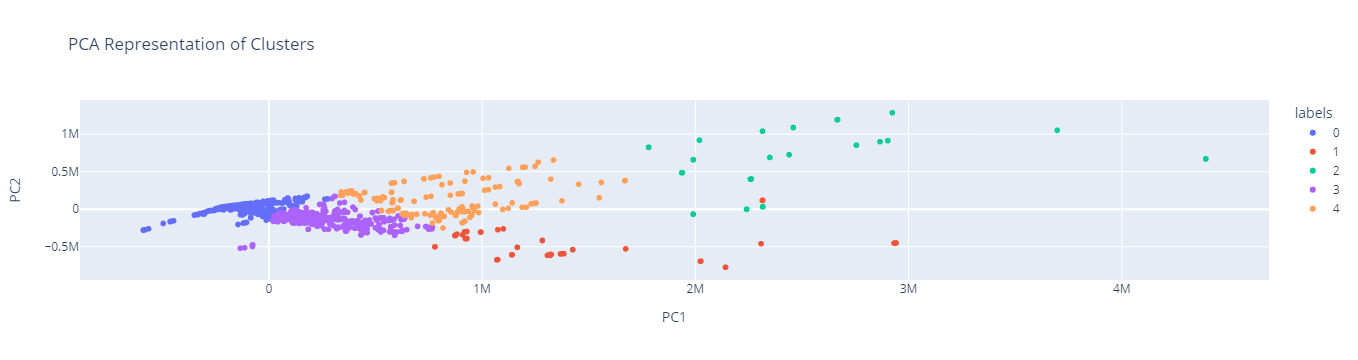

In [34]:
serve_scatter_plot(trimmed=False,k=5)

Again, we finish up by adding some code to make the interactive elements of our app actually work.

In [35]:
VimeoVideo("715725777", h="4b3ecacb85", width=600)

In [37]:
@app.callback(
Output("pca-scatter","figure"),
    Input("trim-button","value"),
    Input("k-slider","value")
)
def serve_scatter_plot(trimmed=True,k=2):

    """Build 2D scatter plot of ``df`` with ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    fig = px.scatter(
    data_frame=get_pca_labels(trimmed=trimmed,k=k),
        x="PC1",
        y="PC2",
        color="labels",
        title="PCA Representation of Clusters"
    )
    fig.update_layout(xaxis_title="PC1",yaxis_title="PC2")
    return fig

In [38]:
app.layout = html.Div(
    [
        # Application title
        html.H1("Survey of Consumer Finances"),
        # Bar chart element
        html.H2("High Variance Features"),
        # Bar chart graph
        dcc.Graph(figure=serve_bar_chart(),id="bar-chart"),
        dcc.RadioItems(
        options=[{"label":"trimmed","value":True},
                 {"label":"not trimmed","value":False}
                ],
            value=True,
            id="trim-button"
        ),
        html.H2("K-means Clustering"),
        html.H3("Number of Clusters (k)"),
        dcc.Slider(min=2,max=12,step=1,value=2,id='k-slider'),
        html.Div(id="metrics"),
        # PCA scatter plot
        dcc.Graph(id="pca-scatter")
    ]
)

**Task 6.4.19:** Add a callback decorator to your `serve_scatter_plot` function. The callback inputs should be the values returned by `"trim-button"` and `"k-slider"`, and the output should be directed to `"pca-scatter"`.

## Application Deployment

Once you're feeling good about all the work we just did, run the cell and watch the app come to life! 

**Task 6.4.20:** Run the cell below to deploy your application. 😎

<div class="alert alert-block alert-info">
<b>Note:</b> We're going to build the layout for our application iteratively. So even though this is the last task, you'll run this cell multiple times as you add features to your application.
</div>

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> If you have issues with your app launching during this project, try restarting your kernel and re-running the notebook from the beginning. Go to <b>Kernel</b> > <b>Restart Kernel and Clear All Outputs</b>.</p>
<p>If that doesn't work, close the browser window for your virtual machine, and then relaunch it from the "Overview" section of the WQU learning platform.</p> 
</div>

In [12]:
app.run_server(host="0.0.0.0", mode="external")

Dash app running on https://vm.wqu.edu/proxy/8050/


---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
